## <center>Иерархическая кластеризация

In [8]:
import numpy as np
import pandas as pd
from scipy.spatial import distance
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')
%matplotlib inline

In [3]:
# df = pd.read_csv("C:/Users/mrtyb/Programming/Shad_Python_02_2/1_beverage/beverage_r.csv", sep=";", index_col='numb.obs')

# df = pd.read_csv("/home/smich/clust/Shad_Python_02_2/1_beverage/beverage_r.csv", sep=";", index_col='numb.obs')

### <center> 1. Метод ближайшего соседа

Объект ```link``` представляет собой матрицу ```(n-1) x 4```, где ```n``` -- число наблюдений. Каждая строка матрицы представляет собой результат слияния очередной пары кластеров с номерами ```link[i, 0]``` и ```link[i, 1]```. Новому кластеру присваивается номер ```n + i```. ```link[i, 2]``` означает расстояние между слитыми кластерами, а ```link[i, 3]``` -- размер нового кластера.

In [5]:
def hierarchical_clustering(M, method='single', metric='euclidean', optimal_ordering=False):
    # Number of observations:
    N = M.shape[0]
    d = M.shape[1]
    
    # Converting matrix M to a list of clusters
    l_M = len(M)
    M = [M[i].reshape(1, 2) for i in range(l_M)]

    link = np.zeros(shape=(N-1,4))
    
    # Calculating the squared Euclidean distances for every pair of points
    # in the N x d dimensional dataset.
    dists = []
    for i in range(l_M):
        for j in range(i + 1, l_M):
            dists.append(calc_dist(M[i], M[j], method = 'single'))
        
    # Converting the pairwise distances into a symmetric N x N matrix.
    mat_dists = distance.squareform(dists)
    np.fill_diagonal(mat_dists, np.inf)
    
    # Array with indexes of clusters
    indexes = [i for i in range(N)]
    
    # Array with numbers of original observations in clusters
    sizes = [1] * N
    
    for i in range(N-1):
        
        # Indexes of clusters:
        k = int(np.unravel_index(np.argmin(mat_dists, axis=None), mat_dists.shape)[0])
        l = int(np.unravel_index(np.argmin(mat_dists, axis=None), mat_dists.shape)[1])
        link[i][0], link[i][1] = indexes[k], indexes[l]
        
        # Distance between clusters:
        link[i][2] = mat_dists[k, l]
        
        # Size of a new cluster:
        link[i][3] = sizes[k] + sizes[l]
        
        # Recalculate matrix M and array indexes:
        
        new_cluster = np.concatenate((M[k], M[l]), axis = 0) 
        # add new cluster in the end
        M = [M[j] for j in range(l_M) if (j != k) and (j != l)]
        M.append(new_cluster)
        
        indexes = [j for j in indexes if (j != link[i][0]) and (j != link[i][1])]
        # add index of the new cluster in the end
        indexes.append(N + i)
        
        l_sizes = len(sizes)
        # remember sizes of concatenated clusters
        size_k, size_l = sizes[k], sizes[l]
        sizes = [sizes[j] for j in range(l_sizes) if (j != k) and (j != l)]
        # add size of the new cluster in the end
        sizes.append(link[i][3])
        
        # Recalculate distance Matrix:
        l_M = len(M)
        dists = []
        for u in range(l_M):
            for j in range(u + 1, l_M):
                u_prototype = u + int(u >= min(k, l)) + ((u + int(u >= min(k, l))) >= max(k, l))
                j_prototype = j + int(j >= min(k, l)) + ((j + int(j >= min(k, l))) >= max(k, l))
                # if distance between new_cluster and smth else
                if j == l_M - 1:
                    dists.append(calc_dist(M[u], M[j], method = method, prev_mat_dists = mat_dists, indexes = (k, l, u_prototype)))
                # if distance between old clusters
                else:
                    dists.append(calc_dist(M[u], M[j], method = method, prev_mat_dists = mat_dists, indexes = (u_prototype, j_prototype)))
        mat_dists = distance.squareform(dists)
        # remember sizes of concatenated clusters
        np.fill_diagonal(mat_dists, np.inf)
        
    return link

In [6]:
# Function for calculating distance between clusters:

def calc_dist(clust_1, clust_2, method = 'single', prev_mat_dists = None, indexes = None):
    
    if method == 'single':
        d = np.inf
        for v in clust_1:
            for u in clust_2:
                d = min(d, distance.euclidean(v, u))
                
    elif method == 'UPGMA':
    # method=’average’ ('UPGMA')
        d = 0
        for v in clust_1:
            for u in clust_2:
                d += distance.euclidean(v, u)
        d = d / (len(clust_1) * len(clust_2))
        
    elif method == 'WPGMA':
    # method=’weighted’ ('WPGMA') 
        if len(indexes) == 3:
            d = (prev_mat_dists[indexes[0], indexes[2]] + prev_mat_dists[indexes[1], indexes[2]]) / 2
        else:
            d = prev_mat_dists[indexes[0], indexes[1]]
            
    else:
        print('No such method')
                
    return d

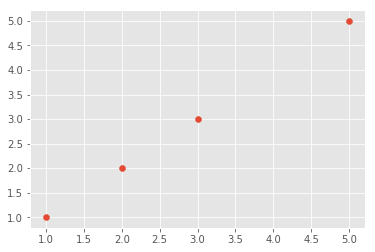

In [84]:
M = np.array([[1, 1], [2, 2], [3, 3], [5, 5]])

plt.scatter(M[:,0], M[:,1]);

In [85]:
link = hierarchical_clustering(M, method='single')

Z = linkage(M, method='single', metric='euclidean', optimal_ordering=False)

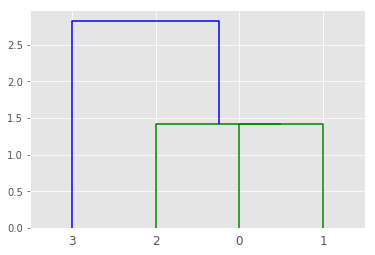

In [86]:
dn = dendrogram(link)

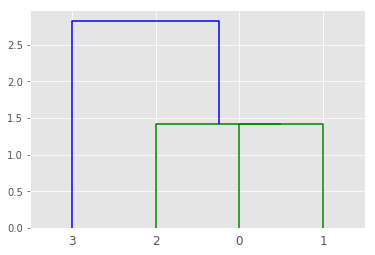

In [87]:
dn = dendrogram(Z)

### <center> 2. WPGMA

In [88]:
link_2 = hierarchical_clustering(M, method='WPGMA')

Z_2 = linkage(M, method='weighted', metric='euclidean', optimal_ordering=False)

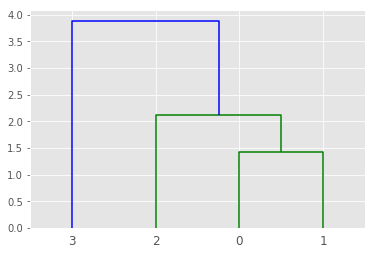

In [89]:
dn = dendrogram(link_2)

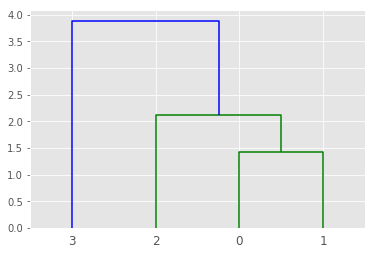

In [90]:
dn = dendrogram(Z_2)

### <center> 3. UPGMA

In [91]:
link_3 = hierarchical_clustering(M, method='UPGMA')

Z_3 = linkage(M, method='average', metric='euclidean', optimal_ordering=False)

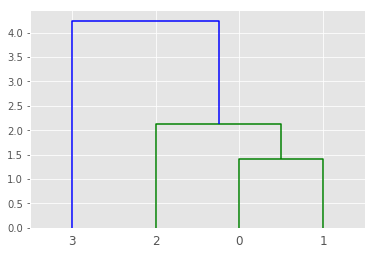

In [92]:
dn = dendrogram(link_3)

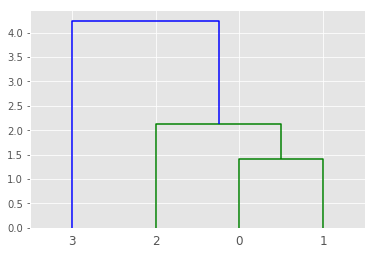

In [93]:
dn = dendrogram(Z_3)

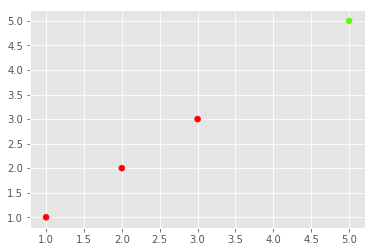

In [94]:
from scipy.cluster.hierarchy import fcluster

clusters = fcluster(link_2, 2, criterion='maxclust')

plt.scatter(M[:,0],M[:,1], c = clusters, cmap='prism');